# Comparing test-statistics: T-Test and Wilcoxon rank sum test for generic Zero-Inflated Negative Binomial  Distribution

In [1]:
import numpy as np
import scanpy.api as sc
from anndata import AnnData
from numpy.random import negative_binomial, binomial, seed

First, data following a (zero-inflated) negative binomial (ZINB) distribution is created for testing purposes. Test size and distribution parameters can be specified.
For a specified number of marker genes in a cluster, distribution of these genes follows a different ZINB distribution. We use the following notation:

$z_r=\text{zero-inflation reference group}$

$z_c=\text{zero-inflation cluster}$

$p_r=\text{success probability reference group}$

$p_c=\text{success probability cluster}$

$n_r=\text{number of successfull draws till stop reference group}$

$n_c=\text{number of successfull draws till stop cluster}$

Let $X_r\sim NegBin(p_r,n_r)$, $Y_r\sim Ber(z_r)$ independent of $X$, then $Z_r=YX\sim ZINB(z_r,p_r,n_r)$ describes the distribution for the all cells/genes except for marker genes in a specified number of clustered cells, which are described using a $ZINB(z_c,p_c,n_c)$ distribution. 

Especially, we have 

$$\mathbb{E}[Z_r]=z_r*n_r*\frac{1-p_r}{p_r}$$

and using standard calculations for expectations and variance, 

$$\mathbb{V}[Z_r]=z_r*n_r\frac{1-p_r}{p_r²}+z_r(1-z_r)(n_r\frac{1-p_r}{p_r})²$$


This form of the ZINB was taken from

https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1293115 (Greene, 1994)


## Tune parameters and create data

In order to demonstrate the superiority of the wilcoxon rank test in certain cases, parameter specifications have to be found that violate the t-test assumptions and therefore make it difficult to detect marker genes. In short: Expectations should be the same, but variance should be different, for the simple reason that expectation differences will be - due to the law of large numbers - detected by the t-test as well, even though the lack of normal distribution means that this may take some time. 

The effect should increase with the magnitude of variance difference, as demonstrated below.
In order for the t-test to fail, little  to no difference in mean should occur. This can be achieved by tuning the parameters using the formula for expectation specified above. 

In [2]:
seed(1234)
# n_cluster needs to be smaller than n_simulated_cells, n_marker_genes needs to be smaller than n_simulated_genes
n_simulated_cells=1000
n_simulated_genes=100
n_cluster=100
n_marker_genes=10
# Specify parameter between 0 and 1 for zero_inflation and p, positive integer for r
# Differential gene expression is simulated using reference parameters for all cells/genes 
# except for marker genes in the distinct cells. 
reference_zero_inflation=0.15
reference_p=0.25
reference_n=2
cluster_zero_inflation=0.9
cluster_p=0.5
cluster_n=1

Create data.
Both sample names and variable names are simply intgers starting from 0. 


In [3]:
adata=AnnData(np.multiply(binomial(1,reference_zero_inflation,(n_simulated_cells,n_simulated_genes)),
                          negative_binomial(reference_n,reference_p,(n_simulated_cells,n_simulated_genes))))
# adapt marker_genes for cluster 
adata.X[0:n_cluster,0:n_marker_genes]=np.multiply(binomial(1,cluster_zero_inflation,(n_cluster,n_marker_genes)),
                                                  negative_binomial(cluster_n,cluster_p,(n_cluster,n_marker_genes)))

## Cluster according to true grouping: 


The following code includes the true grouping such that it can be accessed by normal function calling of 

    sc.tl.rank_genes_groups(adata,'true_groups')
    
or, respectively,

    sc.tl.rank_genes_groups(adata,'true_groups', test_type='wilcoxon')

In [4]:
import pandas as pd
smp='true_groups'
true_groups_int=np.ones((n_simulated_cells,))
true_groups_int[0:n_cluster]=0
true_groups=list()
for i,j  in enumerate(true_groups_int):
    true_groups.append(str(j))
adata.smp['true_groups']=pd.Categorical(true_groups, dtype='category')
adata.uns[smp + '_order']=np.asarray(['0','1'])

## Testing

### Case 1: No mean difference, large variance difference. 

Using the data created above, we get the following expectation and variance 

$\mathbb{E}[Z_r]=\mathbb{E}[Z_c]=0.9$

$\mathbb{V}[Z_r]=8.19$

$\mathbb{V}[Z_c]=1.89$



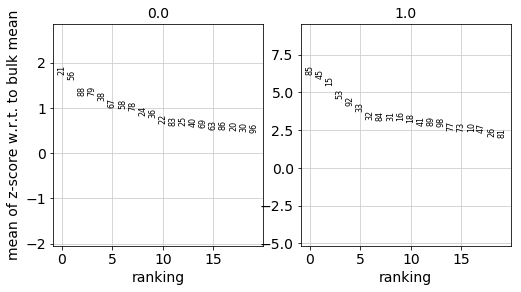

In [5]:
sc.tl.rank_genes_groups(adata, 'true_groups')
sc.pl.rank_genes_groups(adata, n_genes=20)

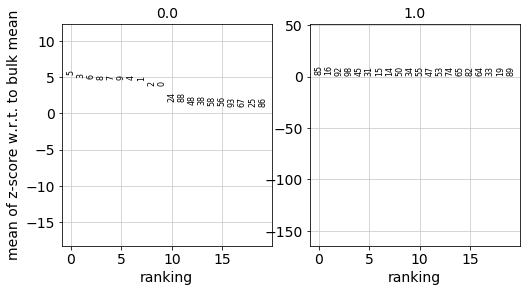

In [6]:
sc.tl.rank_genes_groups(adata, 'true_groups', test_type='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=20)

As can be seen above, not on only does the wilcoxon-rank-sum test detect all marker genes, but there is also a clear difference to all other genes in ranking. 

### Case 2: No mean difference, smaller variance difference

In [7]:
# n_cluster needs to be smaller than n_simulated_cells, n_marker_genes needs to be smaller than n_simulated_genes
n_simulated_cells=1000
n_simulated_genes=100
n_cluster=100
n_marker_genes=10
# Specify parameter between 0 and 1 for zero_inflation and p, positive integer for r
# Differential gene expression is simulated using reference parameters for all cells/genes 
# except for marker genes in the distinct cells. 
reference_zero_inflation=0.15
reference_p=0.5
reference_n=6
cluster_zero_inflation=0.9
cluster_p=0.5
cluster_n=1

This parameter initialization leads to the following expectations/ variances: 

$\mathbb{E}[Z_r]=\mathbb{E}[Z_c]=0.9$

$\mathbb{V}[Z_r]=6.39$

$\mathbb{V}[Z_c]=1.89$


In [8]:
adata=AnnData(np.multiply(binomial(1,reference_zero_inflation,(n_simulated_cells,n_simulated_genes)),
                          negative_binomial(reference_n,reference_p,(n_simulated_cells,n_simulated_genes))))
# adapt marker_genes for cluster 
adata.X[0:n_cluster,0:n_marker_genes]=np.multiply(binomial(1,cluster_zero_inflation,(n_cluster,n_marker_genes)),
                                                  negative_binomial(cluster_n,cluster_p,(n_cluster,n_marker_genes)))

In [9]:
import pandas as pd
smp='true_groups'
true_groups_int=np.ones((n_simulated_cells,))
true_groups_int[0:n_cluster]=0
true_groups=list()
for i,j  in enumerate(true_groups_int):
    true_groups.append(str(j))
adata.smp['true_groups']=pd.Categorical(true_groups, dtype='category')
adata.uns[smp + '_order']=np.asarray(['0','1'])

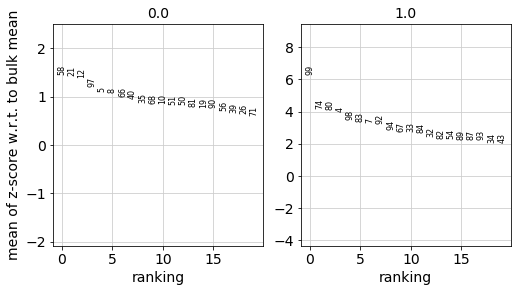

In [10]:
sc.tl.rank_genes_groups(adata, 'true_groups')
sc.pl.rank_genes_groups(adata, n_genes=20)

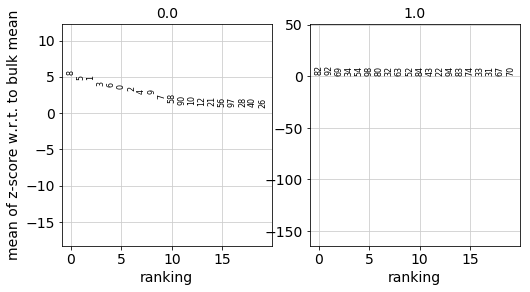

In [11]:
sc.tl.rank_genes_groups(adata, 'true_groups', test_type='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=20)

With smaller difference in variance, still all marker genes are detected, but less clearly. 

## Case 3: Small difference in expectation, difference in variance 

In [12]:
# n_cluster needs to be smaller than n_simulated_cells, n_marker_genes needs to be smaller than n_simulated_genes
n_simulated_cells=1000
n_simulated_genes=100
n_cluster=100
n_marker_genes=10
# Specify parameter between 0 and 1 for zero_inflation and p, positive integer for r
# Differential gene expression is simulated using reference parameters for all cells/genes 
# except for marker genes in the distinct cells. 
reference_zero_inflation=0.15
reference_p=0.5
reference_n=6
cluster_zero_inflation=0.9
cluster_p=0.55
cluster_n=2

This parameter initialization leads to the following expectations/ variances: 

$\mathbb{E}[Z_r]=0.9$

$\mathbb{E}[Z_c]=1.47$

$\mathbb{V}[Z_r]=6.39$

$\mathbb{V}[Z_c]=2.92$


In [13]:
adata=AnnData(np.multiply(binomial(1,reference_zero_inflation,(n_simulated_cells,n_simulated_genes)),
                          negative_binomial(reference_n,reference_p,(n_simulated_cells,n_simulated_genes))))
# adapt marker_genes for cluster 
adata.X[0:n_cluster,0:n_marker_genes]=np.multiply(binomial(1,cluster_zero_inflation,(n_cluster,n_marker_genes)),
                                                  negative_binomial(cluster_n,cluster_p,(n_cluster,n_marker_genes)))

In [14]:
smp='true_groups'
true_groups_int=np.ones((n_simulated_cells,))
true_groups_int[0:n_cluster]=0
true_groups=list()
for i,j  in enumerate(true_groups_int):
    true_groups.append(str(j))
adata.smp['true_groups']=pd.Categorical(true_groups, dtype='category')
adata.uns[smp + '_order']=np.asarray(['0','1'])

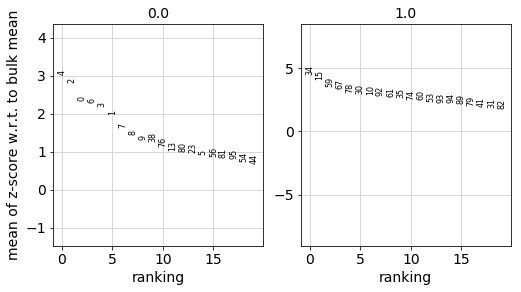

In [15]:
sc.tl.rank_genes_groups(adata, 'true_groups')
sc.pl.rank_genes_groups(adata, n_genes=20)

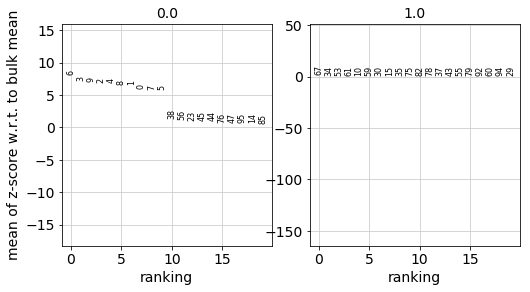

In [16]:
sc.tl.rank_genes_groups(adata, 'true_groups', test_type='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=20)

As can be seen above, t-test fares better as soon as there is a difference in mean exists and difference in vairance decreases, but the ranking is less still worse